#libs

In [1]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 7.1 MB/s eta 0:00:00


In [2]:
pip install hyperopt

In [3]:
pip install bayesian-optimization

In [4]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.3 MB/s eta 0:00:00


In [5]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.6 MB/s eta 0:00:00


In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from sklearn.ensemble import  GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from yellowbrick.regressor import ResidualsPlot



from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from bayes_opt import BayesianOptimization

#data

In [2]:
df=pd.read_excel('data-final.xlsx',sheet_name='paper1')

In [3]:
# Separate features (X) and target variable (y)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [4]:
X.drop(['Urbach_energy','PL_relative_intensity_1', 'PL_relative_intensity_2'],axis=1,inplace=True)

##split and scale data

In [5]:
#split and scale data
def split_and_scale_data(x, y, test_size=0.2, random_state=0):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

#⏩️

In [6]:
X_train, X_test, y_train, y_test = split_and_scale_data(X, y, test_size=0.2, random_state=78)

#feature_importances

In [7]:
def get_feature_importances(model, X):
    # Assuming X is the DataFrame of features
    importances = model.feature_importances_
    importance_scores = list(zip(X.columns, importances))
    importance_scores.sort(key=lambda x: x[1], reverse=True)
    importance_df = pd.DataFrame(importance_scores, columns=['Feature', 'Importance'])

    return importance_df

#shap value plots

In [8]:
def plot_shap_values(model,X, X_train, X_test):
    """
    Calculate and plot SHAP values for both train and test sets.

    Parameters:
    - model: The trained model to explain.
    - X: The feature matrix.
    - X_train: Training data (features).
    - X_test: Testing data (features).
    """
    explainer = shap.Explainer(model, feature_names=X.columns)
    shap_values_train = explainer(X_train)
    shap_values_test = explainer(X_test)

    # Plot SHAP summary plot for test set
    shap.summary_plot(shap_values_test, X_test, feature_names=X.columns, show=False, plot_size=[8, 6])
    plt.title('SHAP Values (Test Set)')
    plt.show()
    # Plot SHAP summary plot for train set
    shap.summary_plot(shap_values_train, X_train, feature_names=X.columns, show=False, plot_size=[8, 6])
    plt.title('SHAP Values (Train Set)')
    plt.show()



    # Plot SHAP bar plot for test set (local)
    plt.title('SHAP Values Local bar plot (Test Set)')
    shap.plots.bar(shap_values_test[0], max_display=26)
    plt.show()
    # Plot SHAP bar plot for train set (local)
    plt.title('SHAP Values Local bar plot (Train Set)')
    shap.plots.bar(shap_values_train[0], max_display=26)
    plt.show()



    # Plot SHAP bar plot for test set (global)
    plt.title('SHAP Values Global bar plot (Test Set)')
    shap.plots.bar(shap_values_test, max_display=26)
    plt.show()

    # Plot SHAP bar plot for train set (global)
    plt.title('SHAP Values Global bar plot (Train Set)')
    shap.plots.bar(shap_values_train, max_display=26)
    plt.show()

#GBR

##Bayesian optimization

In [9]:
#  the objective function for Bayesian optimization (GBR)
def gbr_evaluate(n_estimators, learning_rate, max_depth, subsample, alpha):
    model = GradientBoostingRegressor(
        n_estimators=int(n_estimators),
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        subsample=subsample,
        alpha=alpha,  # Regularization parameter
        random_state=0
    )
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    return -rmse_test  # Minimize the negative RMSE for Bayesian optimization

# Define the parameter search space for GBR
gbr_search_space = {
    'n_estimators': (50, 100),
    'learning_rate': (0.01, 1.0),
    'max_depth': (2, 10),
    'subsample': (0.5, 1.0),
    'alpha': (0.01, 0.1)  # Regularization parameter (L1 and L2)
}

# Perform Bayesian optimization for GBR
optimizer = BayesianOptimization(
    f=gbr_evaluate,
    pbounds=gbr_search_space,
    random_state=0
)

optimizer.maximize(init_points=5, n_iter=10)

# Get the best hyperparameters for GBR
gbr_best_params = optimizer.max['params']
gbr_best_params['n_estimators'] = int(gbr_best_params['n_estimators'])
gbr_best_params['max_depth'] = int(gbr_best_params['max_depth'])


# Train the GBR model with the best hyperparameters
gbr_best_model = GradientBoostingRegressor(**gbr_best_params, random_state=0)
gbr_best_model.fit(X_train, y_train)

# Make predictions on the training and testing sets
y_pred_train = gbr_best_model.predict(X_train)
y_pred_test = gbr_best_model.predict(X_test)

# Results
res = pd.DataFrame({
    'R-squared Score (Test Set)': [r2_score(y_test, y_pred_test)],
    'R-squared Score (Train Set)': [r2_score(y_train, y_pred_train)],
    'RMSE (Test Set)': [np.sqrt(mean_squared_error(y_test, y_pred_test))],
    'RMSE (Train Set)': [np.sqrt(mean_squared_error(y_train, y_pred_train))],
    'Best max_depth': [gbr_best_params['max_depth']],
    'Best learning_rate': [gbr_best_params['learning_rate']],
    'Best n_estimators': [gbr_best_params['n_estimators']],
    'Best subsample': [gbr_best_params['subsample']],
    'Best alpha': [gbr_best_params['alpha']],
}, index=['GradientBoostingRegressor-BayesianOptimization'])

|   iter    |  target   |   alpha   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | -0.3648   | 0.05939   | 0.718     | 6.822     | 77.24     | 0.7118    |
| 2         | -0.4153   | 0.06813   | 0.4432    | 9.134     | 98.18     | 0.6917    |
| 3         | -0.3644   | 0.08126   | 0.5336    | 6.544     | 96.28     | 0.5355    |
| 4         | -0.1906   | 0.01784   | 0.03002   | 8.661     | 88.91     | 0.935     |
| 5         | -0.4208   | 0.09808   | 0.8012    | 5.692     | 89.03     | 0.5591    |
| 6         | -0.2147   | 0.01912   | 0.01622   | 8.632     | 88.93     | 0.9475    |
| 7         | -0.53     | 0.09754   | 0.9905    | 7.087     | 57.65     | 0.6576    |
| 8         | -0.2127   | 0.1       | 0.1846    | 8.844     | 88.87     | 0.9583    |
| 9         | -0.3659   | 0.01      | 0.01      | 8.763     | 88.66     | 0.7224    |
| 10        | -0.3548   | 0.05534   | 0.3924    | 8.86

In [10]:
res

,R-squared Score (Test Set),R-squared Score (Train Set),RMSE (Test Set),RMSE (Train Set),Best max_depth,Best learning_rate,Best n_estimators,Best subsample,Best alpha
GradientBoostingRegressor-BayesianOptimization,0.928014,0.993192,0.190619,0.056835,8,0.030016,88,0.935006,0.017842


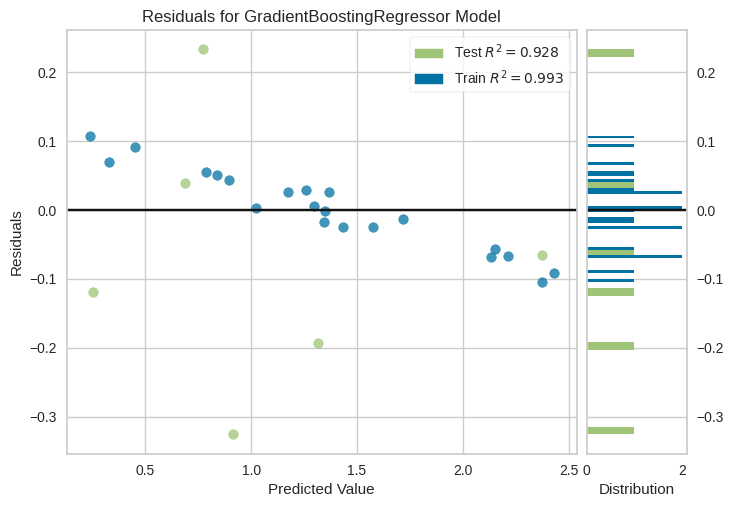

In [11]:
visualizer = ResidualsPlot(gbr_best_model)
visualizer.score(X_test,y_test)
visualizer.fit(X_train,y_train)
visualizer.show()
plt.show()

In [12]:
get_feature_importances(gbr_best_model, X)

,Feature,Importance
0,Drop,0.411772
1,PL_fwhm_2,0.085400
2,FWHM1,0.067591
3,PL_intensity_2,0.052977
4,FWHM6,0.048139
5,PL_peak_positions_1,0.042022
6,FWHM4,0.041281
7,FWHM5,0.039734
8,FWHM2,0.034976
9,rel_int1,0.033841


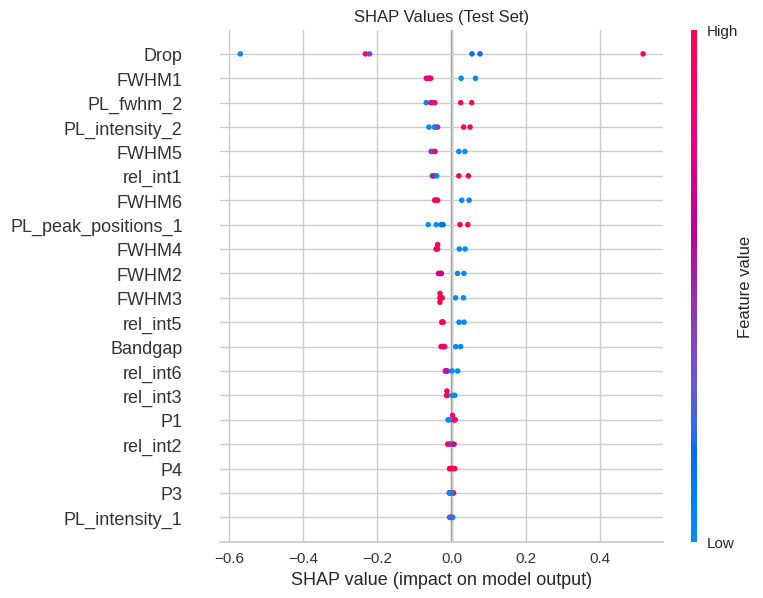

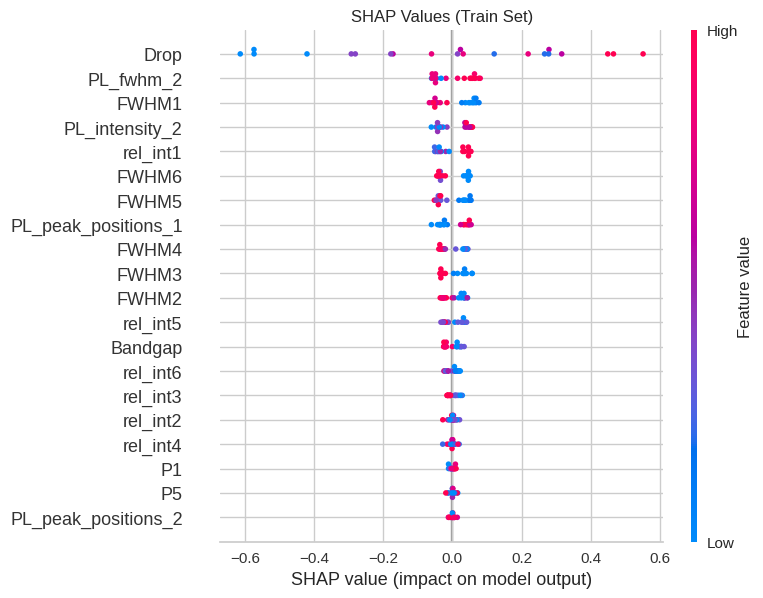

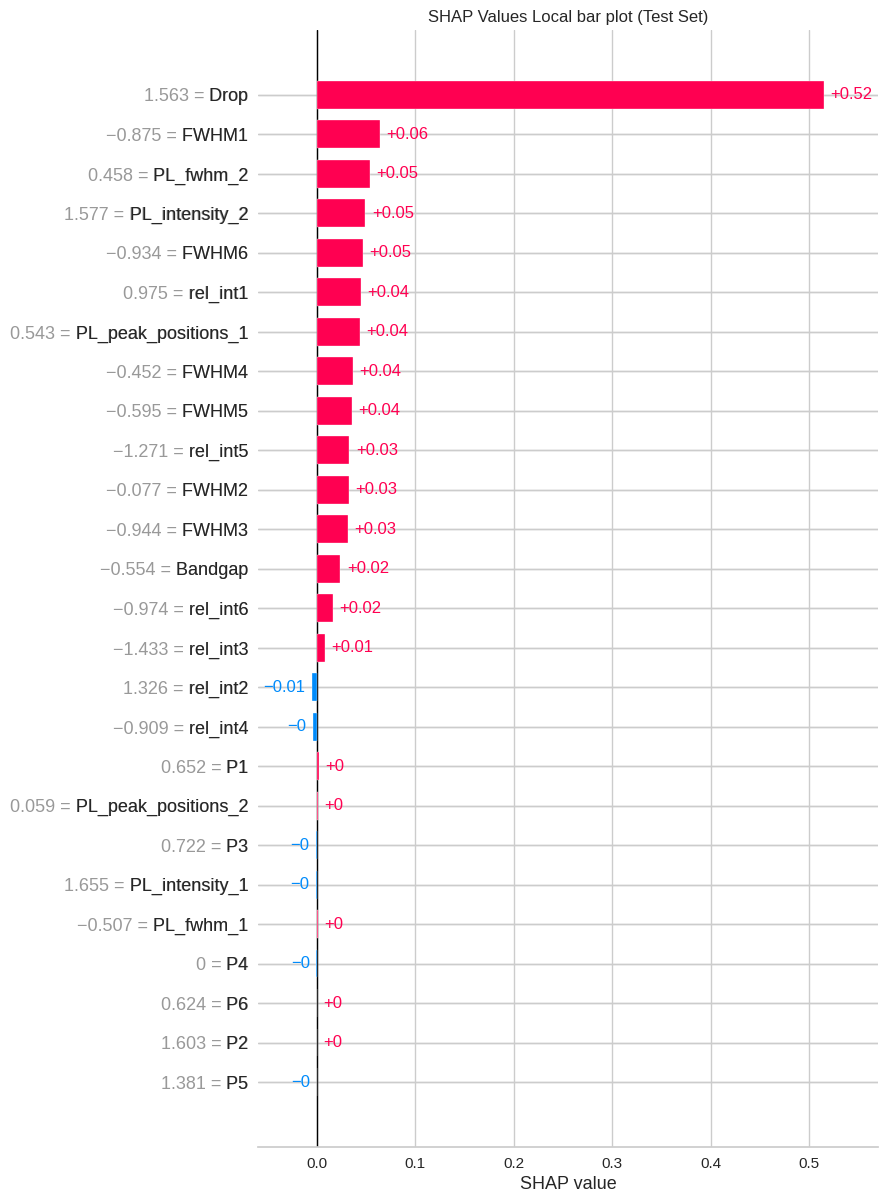

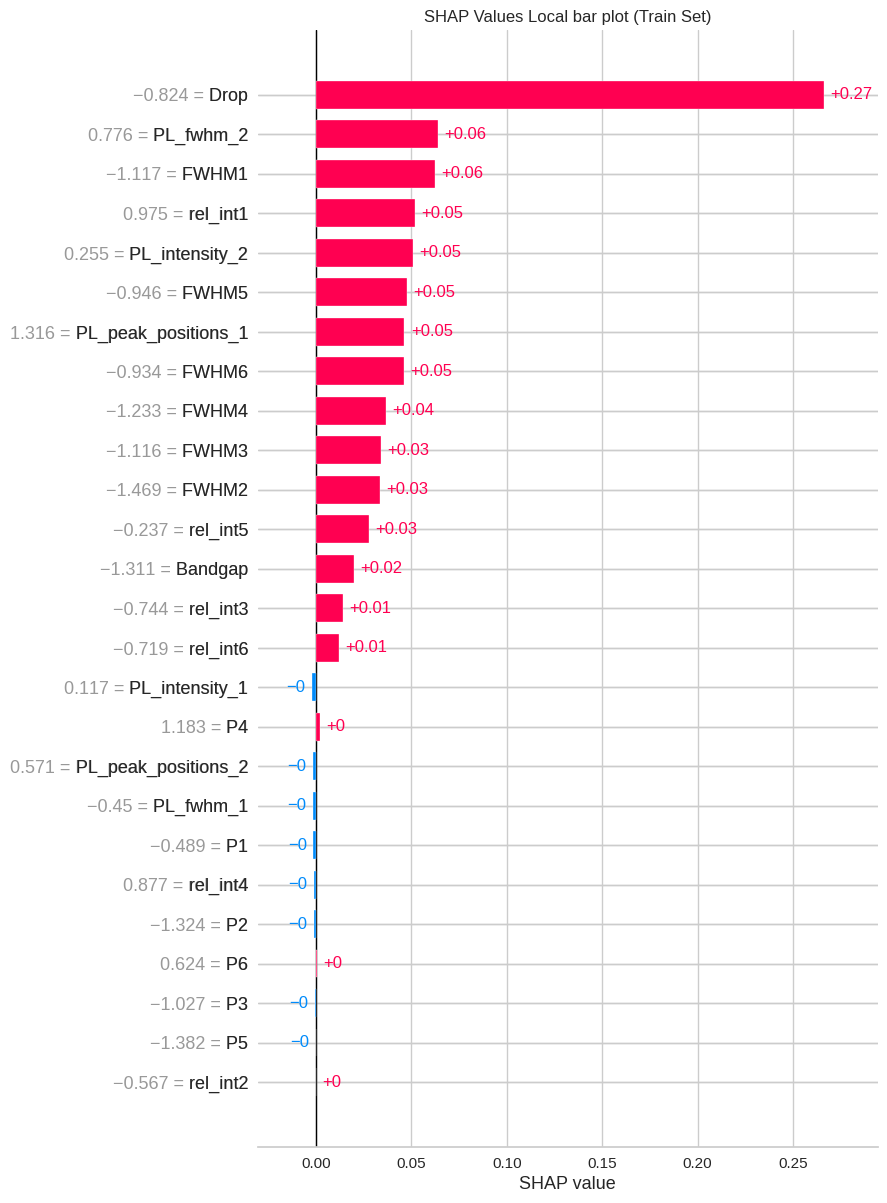

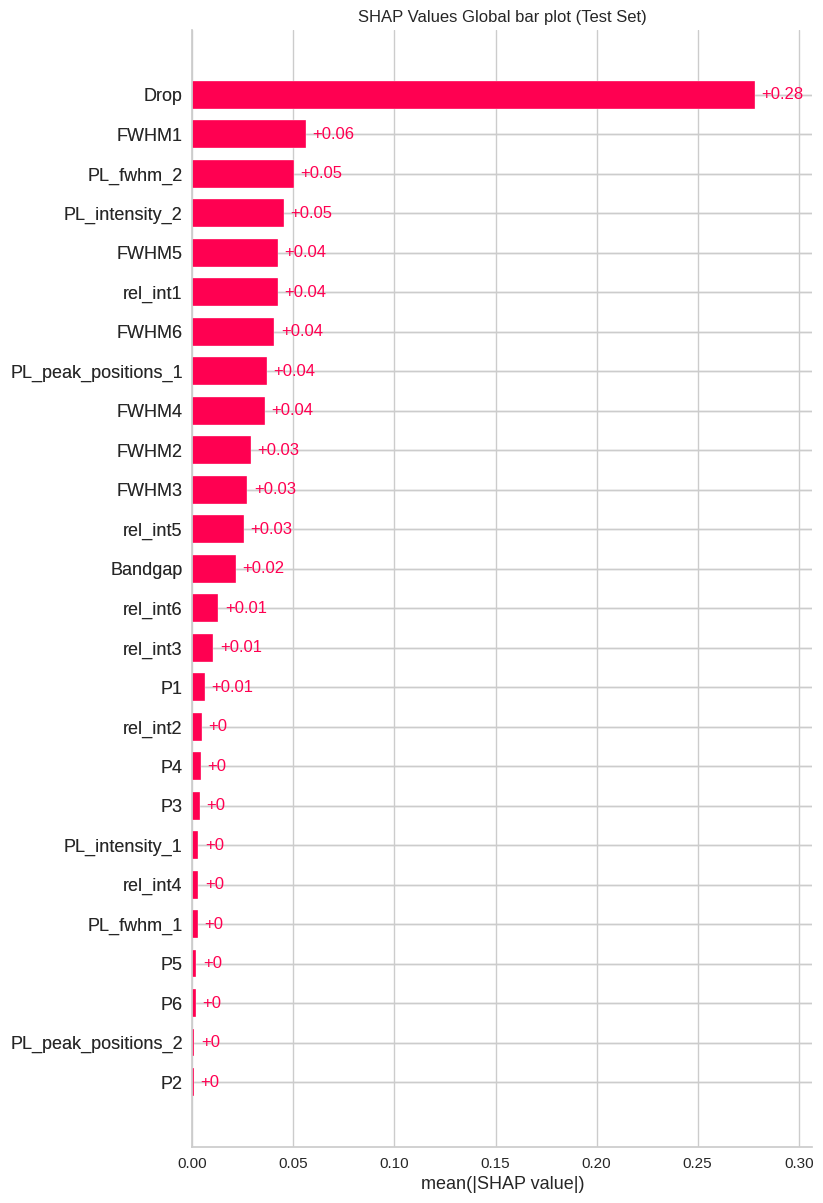

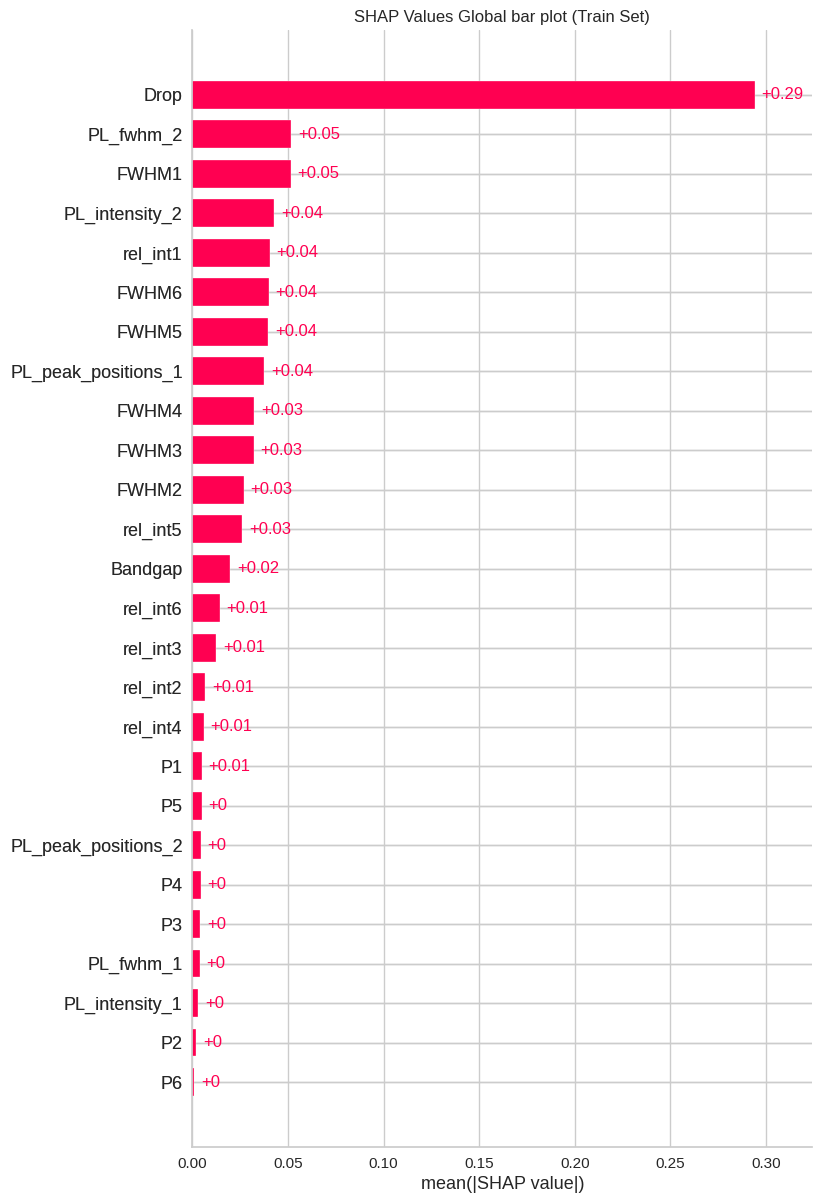

In [13]:
plot_shap_values(gbr_best_model, X,X_train, X_test)

##hyperopt

In [14]:
# Define the objective function for TPE optimization

def gbr_evaluate(params):
    model = GradientBoostingRegressor(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        subsample=params['subsample'],
        alpha=params['alpha'],  # Regularization parameter
        random_state=0
    )
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    return {'loss': rmse_test, 'status': STATUS_OK}

# Define the parameter search space for GBR
gbr_search_space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'max_depth': hp.quniform('max_depth', 2, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'alpha': hp.loguniform('alpha', np.log(0.01), np.log(0.1))  # Regularization parameter (L1 and L2)
}

# Perform TPE optimization for GBR
gbr_trials = Trials()
gbr_best_params = fmin(
    fn=gbr_evaluate,
    space=gbr_search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=gbr_trials,
    rstate=np.random.default_rng(0)
)

# Get the best hyperparameters for GBR
gbr_best_params['n_estimators'] = int(gbr_best_params['n_estimators'])
gbr_best_params['max_depth'] = int(gbr_best_params['max_depth'])
print(f"Best hyperparameters for GBR: {gbr_best_params}")

# Train the GBR model with the best hyperparameters
gbr_best_model = GradientBoostingRegressor(**gbr_best_params, random_state=0)
gbr_best_model.fit(X_train, y_train)

# Make predictions on the training and testing sets (GBR)
gbr_y_pred_train = gbr_best_model.predict(X_train)
gbr_y_pred_test = gbr_best_model.predict(X_test)



res = pd.DataFrame({
    'R-squared Score (Test Set)': [r2_score(y_test, gbr_y_pred_test)],
    'R-squared Score (Train Set)': [r2_score(y_train, gbr_y_pred_train)],
    'RMSE (Test Set)': [np.sqrt(mean_squared_error(y_test, gbr_y_pred_test))],
    'RMSE (Train Set)': [np.sqrt(mean_squared_error(y_train, gbr_y_pred_train))],
    'Best max_depth': [gbr_best_params['max_depth']],
    'Best learning_rate': [gbr_best_params['learning_rate']],
    'Best n_estimators': [gbr_best_params['n_estimators']],
    'Best subsample': [gbr_best_params['subsample']],
    'Best alpha': [gbr_best_params['alpha']],
}, index=['GradientBoostingRegressor-TPE'])

100%|██████████| 50/50 [00:11<00:00,  4.48trial/s, best loss: 0.18920826318708206]
Best hyperparameters for GBR: {'alpha': 0.011879789706259828, 'learning_rate': 0.010814356415977496, 'max_depth': 7, 'n_estimators': 388, 'subsample': 0.887638700238501}


In [15]:
res

,R-squared Score (Test Set),R-squared Score (Train Set),RMSE (Test Set),RMSE (Train Set),Best max_depth,Best learning_rate,Best n_estimators,Best subsample,Best alpha
GradientBoostingRegressor-TPE,0.929075,0.999276,0.189208,0.018532,7,0.010814,388,0.887639,0.01188


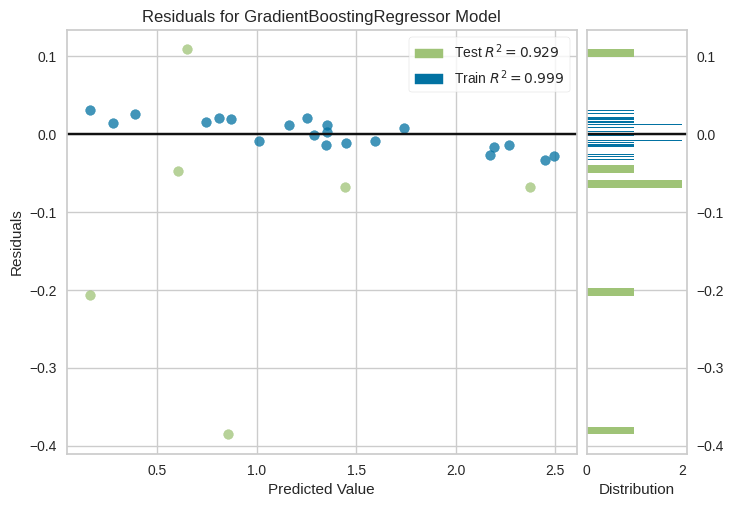

In [16]:
visualizer = ResidualsPlot(gbr_best_model)
visualizer.score(X_test,y_test)
visualizer.fit(X_train,y_train)
visualizer.show()
plt.show()

In [17]:
feature_importances = get_feature_importances(gbr_best_model, X)
feature_importances

,Feature,Importance
0,Drop,0.419200
1,rel_int1,0.067038
2,FWHM6,0.052329
3,FWHM3,0.048165
4,PL_peak_positions_1,0.045405
5,FWHM4,0.040269
6,PL_fwhm_2,0.038575
7,rel_int6,0.037777
8,rel_int5,0.036756
9,PL_intensity_2,0.036108


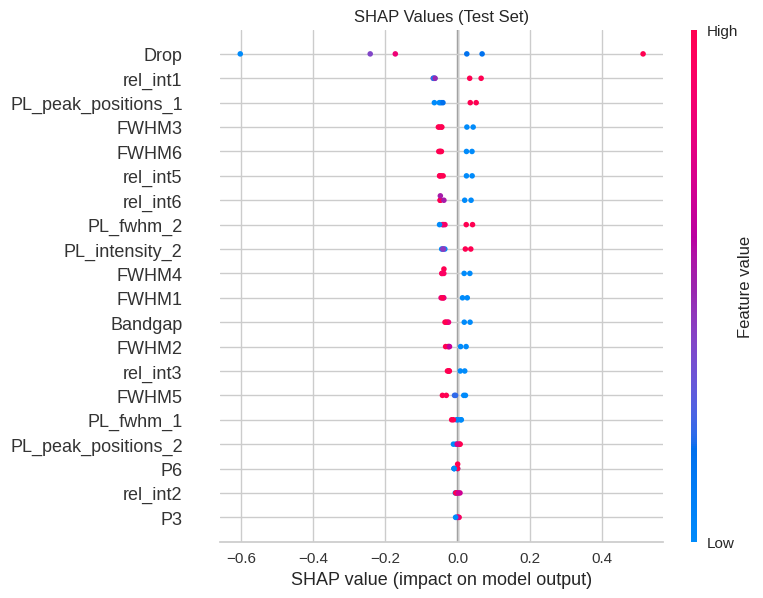

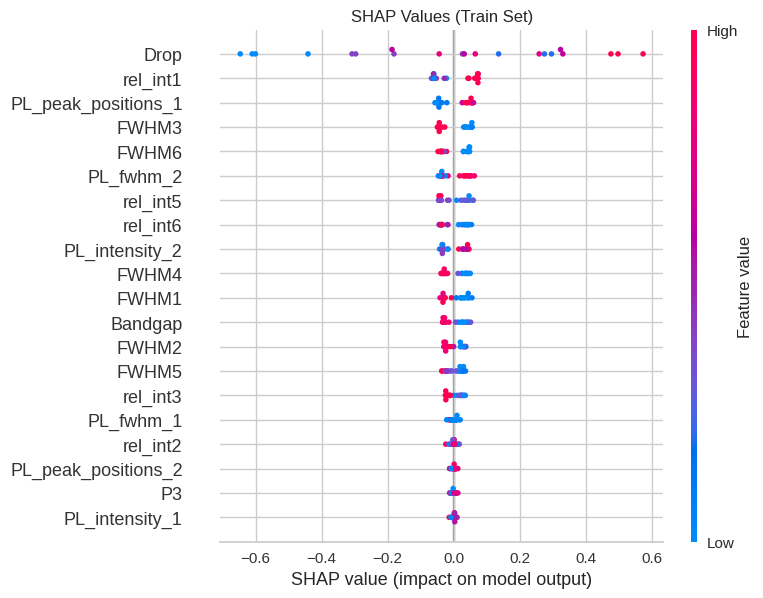

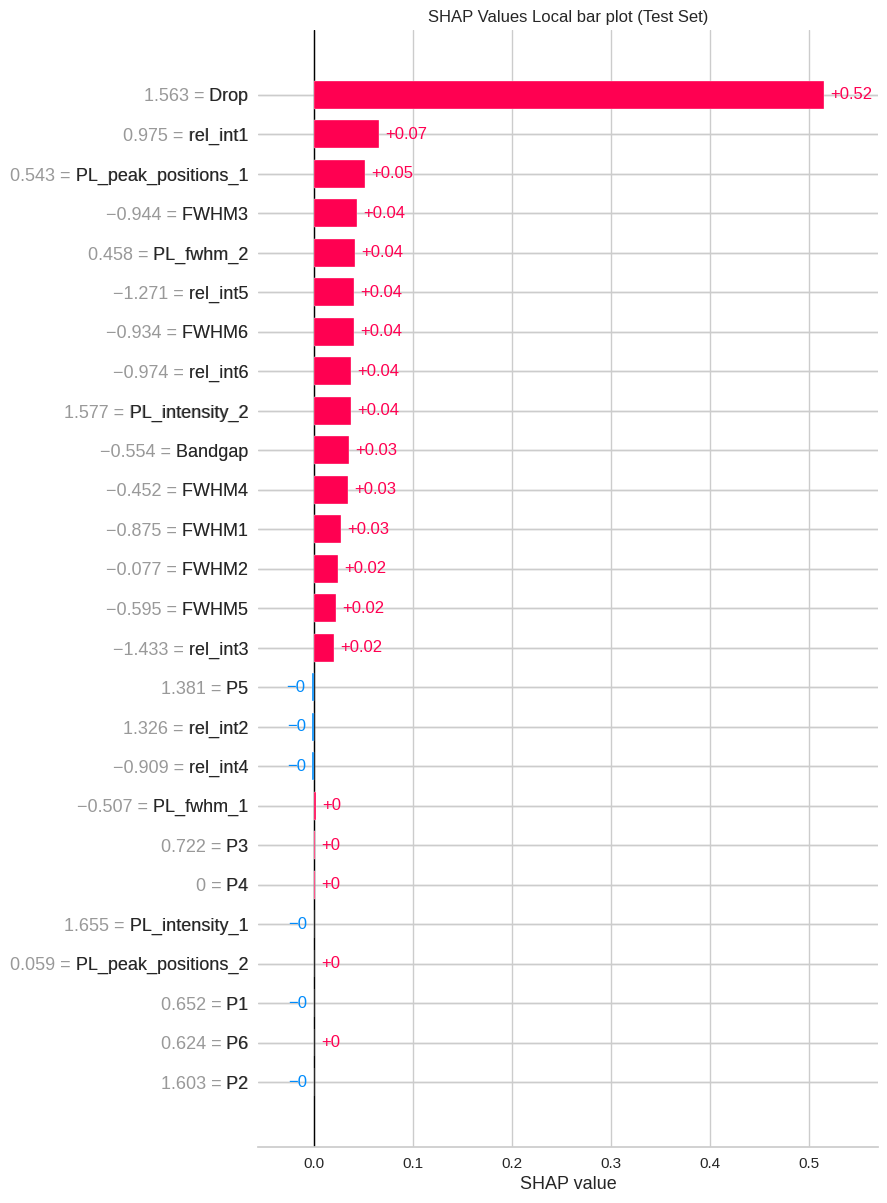

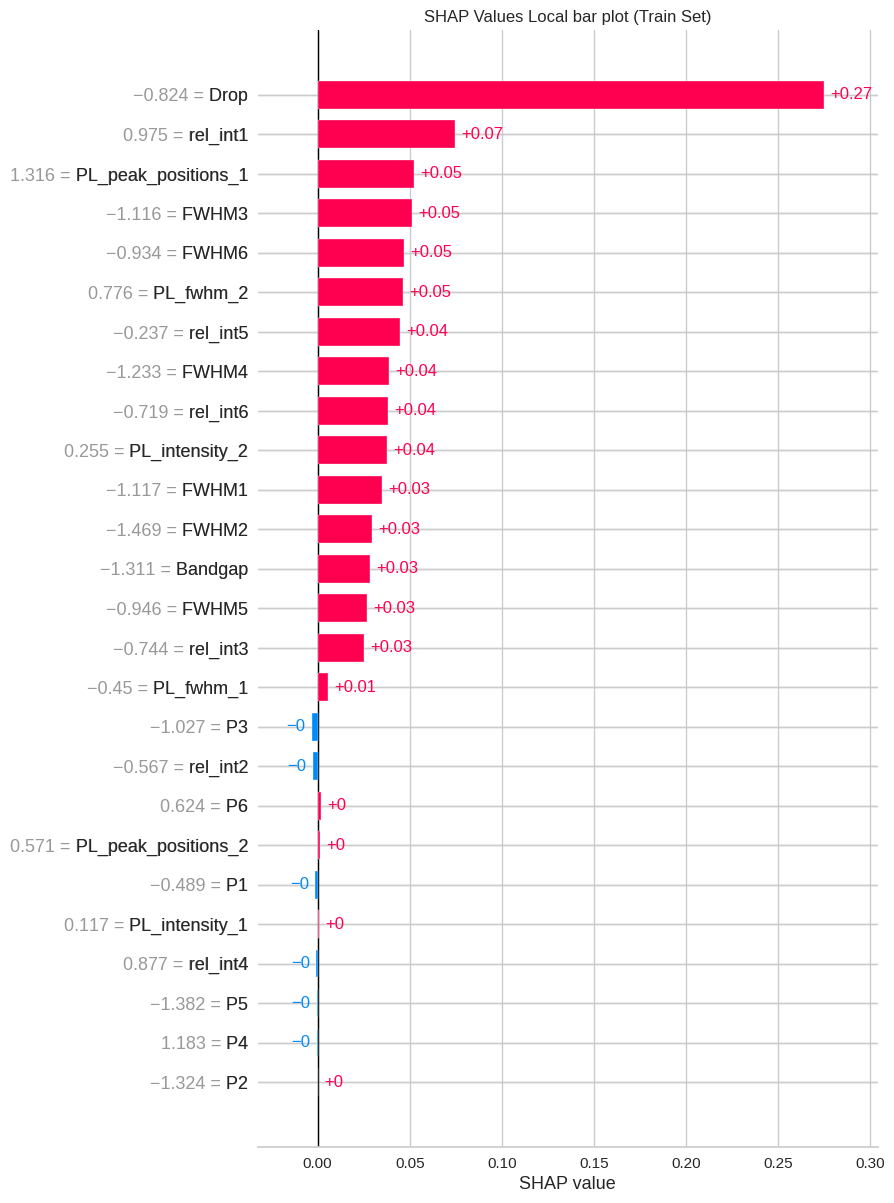

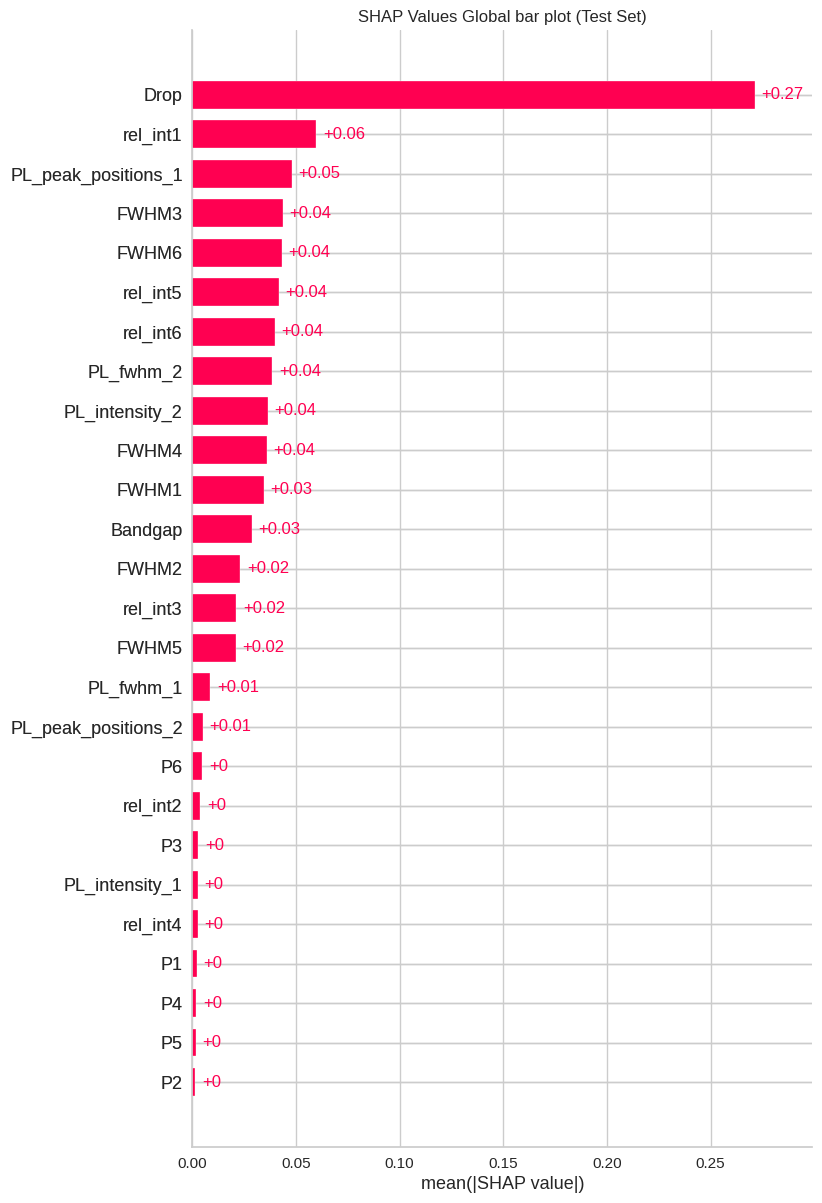

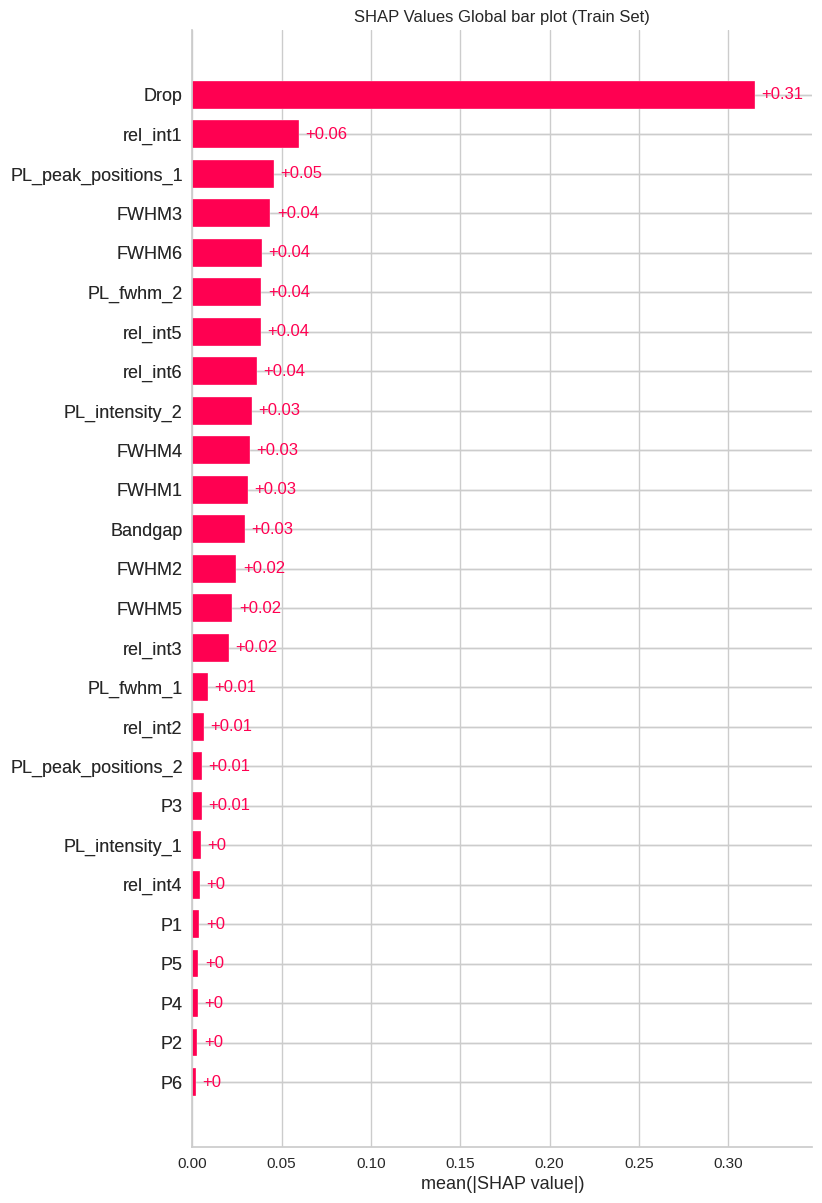

In [18]:
shap_values = plot_shap_values(gbr_best_model, X, X_train, X_test)

#catboost

##Bayesian Optimization

In [19]:
def catboost_evaluate(learning_rate, depth, l2_leaf_reg, subsample, rsm, iterations):
    model = CatBoostRegressor(
        learning_rate=learning_rate,
        depth=int(depth),
        l2_leaf_reg=l2_leaf_reg,
        subsample=subsample,
        rsm=rsm,
        iterations=int(iterations),
        random_seed=78,
        verbose=False
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Define the search space
pbounds = {
    'learning_rate': (0.01, 0.09),
    'depth': (3, 10),
    'l2_leaf_reg': (0, 5),
    'subsample': (0.5, 1.0),
    'rsm': (0.5, 1.0),
    'iterations': (50, 1000)
}

# Perform Bayesian Optimization
optimizer = BayesianOptimization(f=catboost_evaluate, pbounds=pbounds, random_state=78)
optimizer.maximize(init_points=3, n_iter=20)

# Get the best parameters
best_params = optimizer.max['params']
best_params['depth'] = int(best_params['depth'])
best_params['iterations'] = int(best_params['iterations'])

# Train the best model
best_model = CatBoostRegressor(random_seed=78, verbose=False, **best_params)
best_model.fit(X_train, y_train)


# Predictions on the test set and train set
y_pred_test = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)



# Results DataFrame
res = pd.DataFrame({
    'R-squared Score (Test Set)': [r2_score(y_test, y_pred_test)],
    'R-squared Score (Train Set)': [r2_score(y_train, y_pred_train)],
    'RMSE (Test Set)': [np.sqrt(mean_squared_error(y_test, y_pred_test))],
    'RMSE (Train Set)': [np.sqrt(mean_squared_error(y_train, y_pred_train))],
    'Best depth': [best_params['depth']],
    'Best learning_rate': [best_params['learning_rate']],
    'Best iterations': [best_params['iterations']],
    'Best subsample': [best_params['subsample']],
    'Best l2_leaf_reg': [best_params['l2_leaf_reg']],
    'Best rsm': [best_params['rsm']]
}, index=['CatBoost-Bayesian Optimization'])

res

|   iter    |  target   |   depth   | iterat... | l2_lea... | learni... |    rsm    | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.7518    | 3.337     | 696.9     | 3.993     | 0.07401   | 0.9826    | 0.722     |
| 2         | 0.703     | 8.819     | 284.2     | 0.2514    | 0.04899   | 0.8251    | 0.9605    |
| 3         | 0.6826    | 8.171     | 285.1     | 2.59      | 0.06313   | 0.6464    | 0.9368    |
| 4         | 0.7006    | 5.597     | 699.1     | 1.064     | 0.03418   | 0.6332    | 0.5292    |
| 5         | 0.7241    | 3.0       | 695.8     | 5.0       | 0.09      | 1.0       | 0.8302    |
| 6         | 0.745     | 3.0       | 698.2     | 4.365     | 0.07008   | 1.0       | 0.5972    |
| 7         | 0.6778    | 3.0       | 696.7     | 2.132     | 0.05541   | 1.0       | 0.5       |
| 8         | 0.7974    | 3.824     | 697.4     | 4.792     | 0.08047   | 0.959     | 0.8572    |
| 9         | 0.741 

,R-squared Score (Test Set),R-squared Score (Train Set),RMSE (Test Set),RMSE (Train Set),Best depth,Best learning_rate,Best iterations,Best subsample,Best l2_leaf_reg,Best rsm
CatBoost-Bayesian Optimization,0.846103,0.856312,0.278713,0.2611,3,0.013204,562,1.0,2.720623,1.0


In [20]:
feature_importances = get_feature_importances(best_model, X)
feature_importances

,Feature,Importance
0,Drop,34.759941
1,rel_int3,6.527918
2,FWHM5,5.897152
3,rel_int6,5.006859
4,PL_intensity_2,4.864600
5,FWHM6,4.718450
6,rel_int1,4.096294
7,FWHM1,3.970410
8,Bandgap,3.484020
9,FWHM2,3.412269


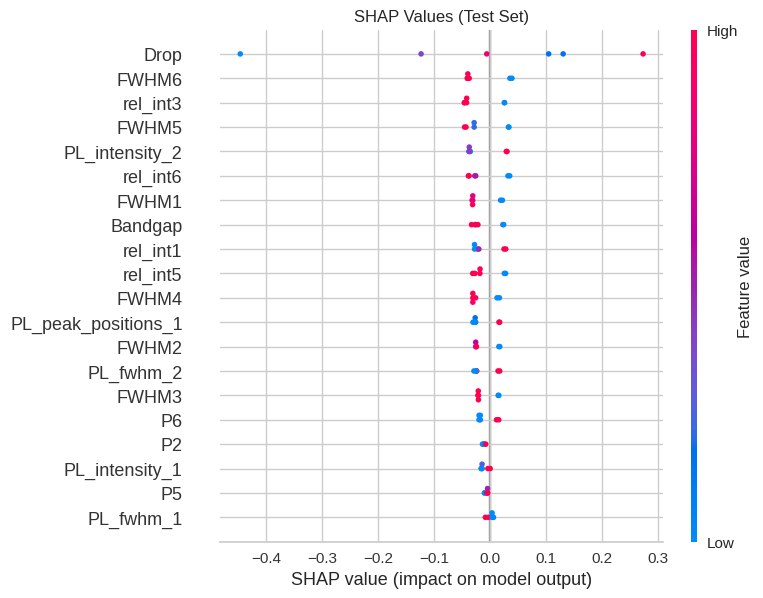

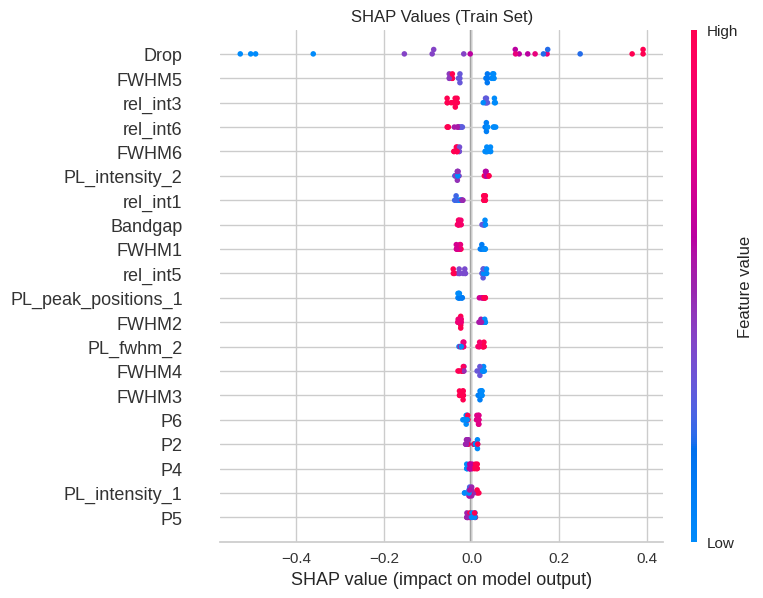

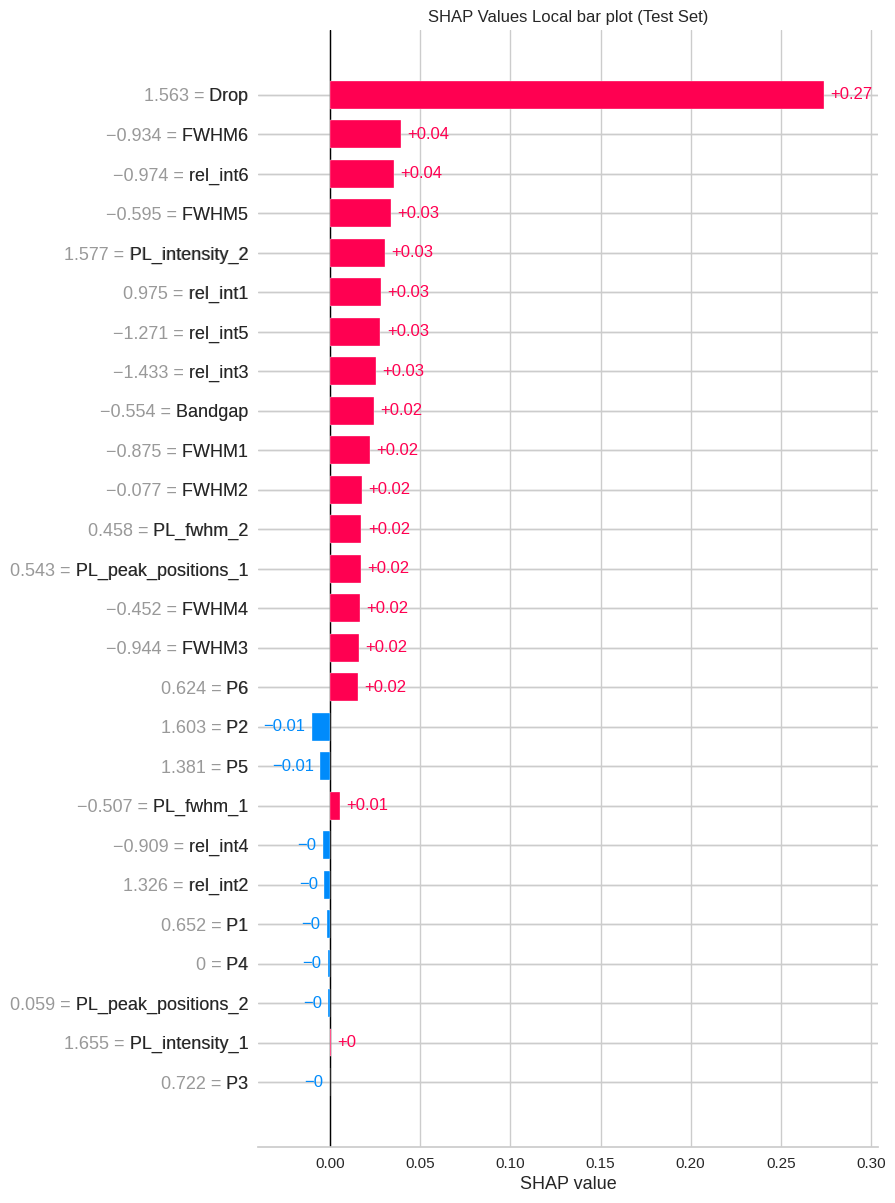

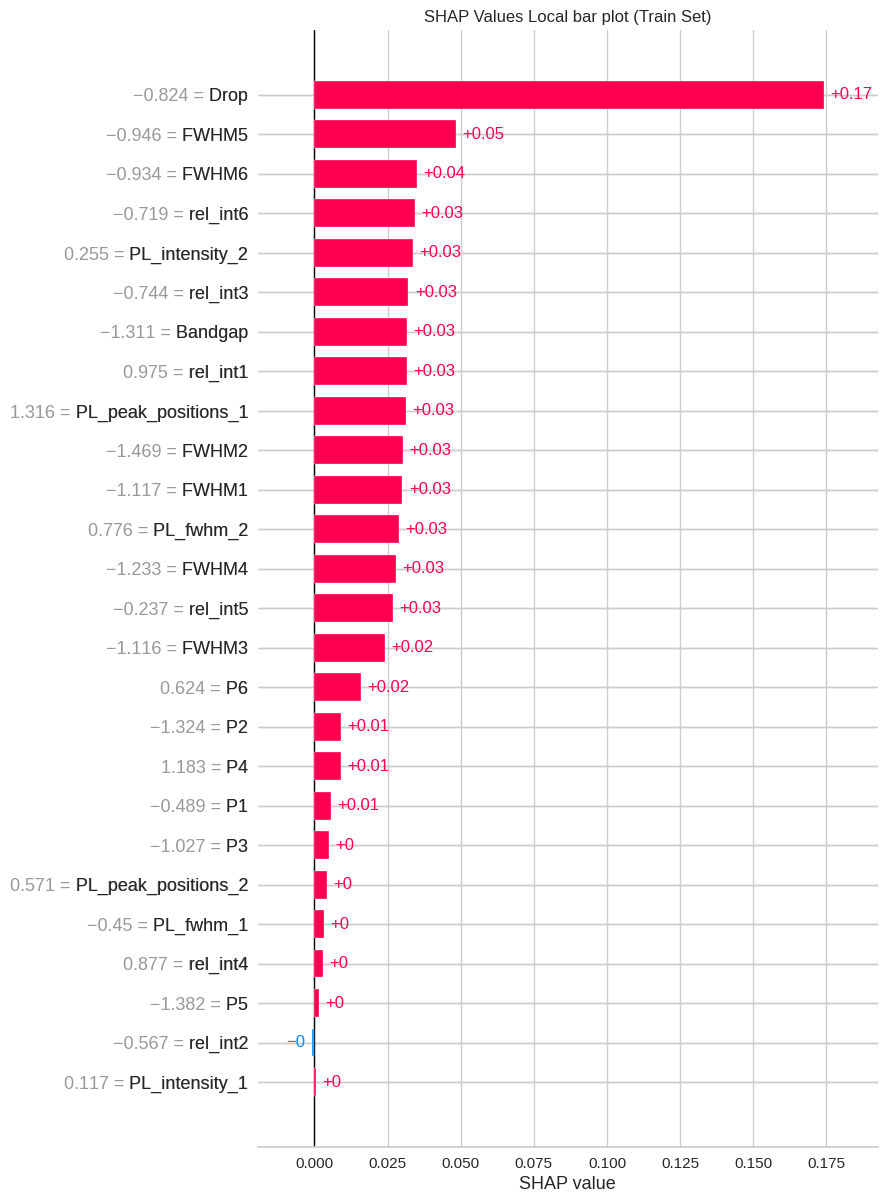

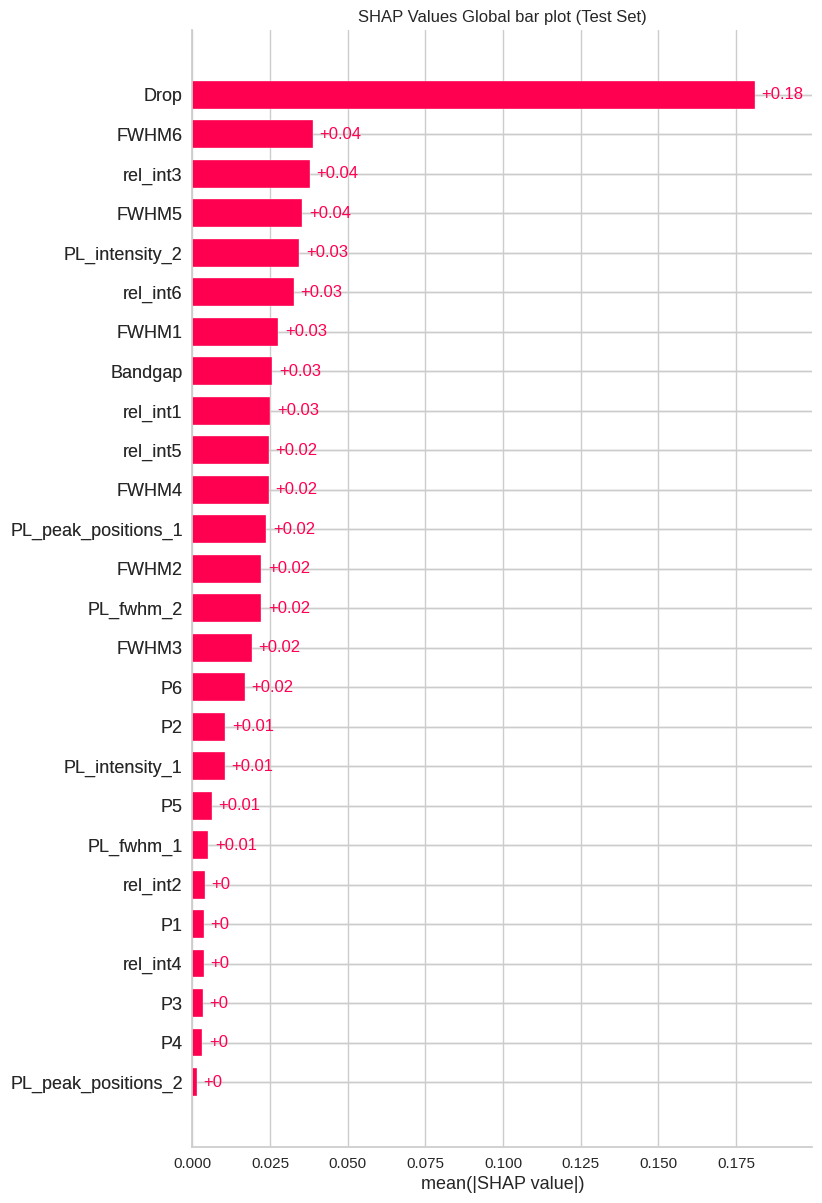

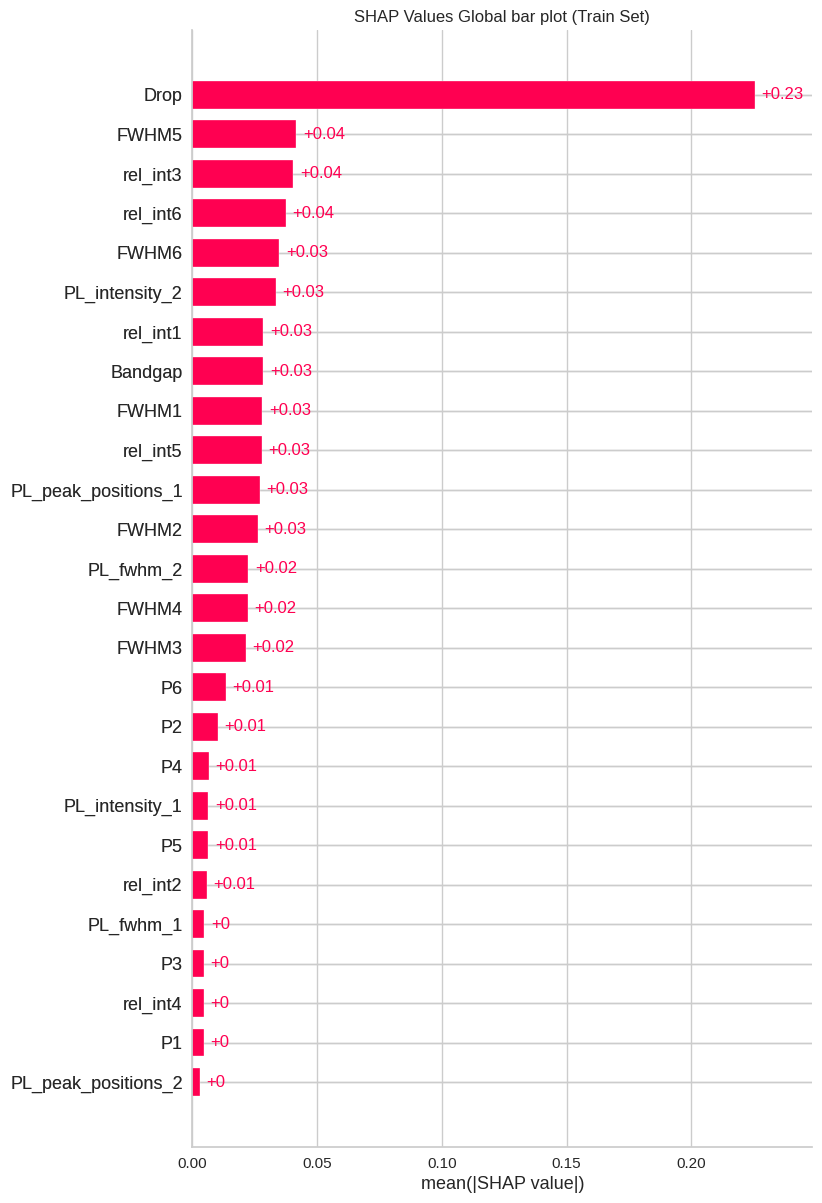

In [21]:
shap_values = plot_shap_values(best_model, X, X_train, X_test)

#Xgboost

##Bayesian Optimization

|   iter    |  target   |   alpha   | learni... | max_depth | n_esti... | reg_la... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.7743    | 0.04818   | 0.06448   | 8.591     | 810.1     | 0.9653    | 0.722     |
| 2         | 0.7411    | 0.8312    | 0.02973   | 3.352     | 513.1     | 0.6502    | 0.9605    |
| 3         | 0.7726    | 0.7387    | 0.02979   | 6.626     | 680.9     | 0.2928    | 0.9368    |
| 4         | 0.8068    | 0.424     | 0.06272   | 3.813     | 926.3     | 0.3717    | 0.8829    |
| 5         | 0.8239    | 0.9248    | 0.06103   | 4.097     | 927.2     | 0.1208    | 0.7235    |
| 6         | 0.8195    | 0.7806    | 0.05791   | 4.845     | 929.4     | 0.02908   | 0.5078    |
| 7         | 0.8128    | 1.0       | 0.07459   | 7.59      | 927.2     | 0.0       | 0.5       |
| 8         | 0.7105    | 1.0       | 0.01      | 10.0      | 932.1     | 1.0       | 1.0       |
| 9         | 0.8096

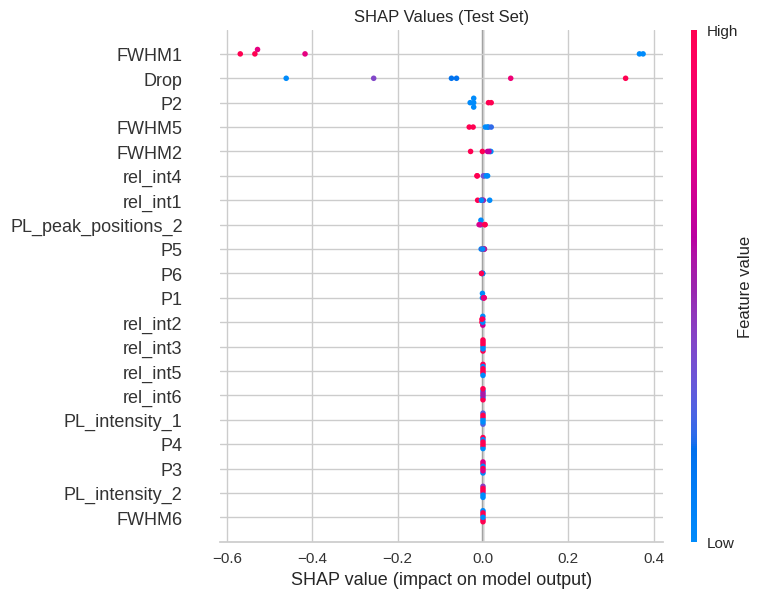

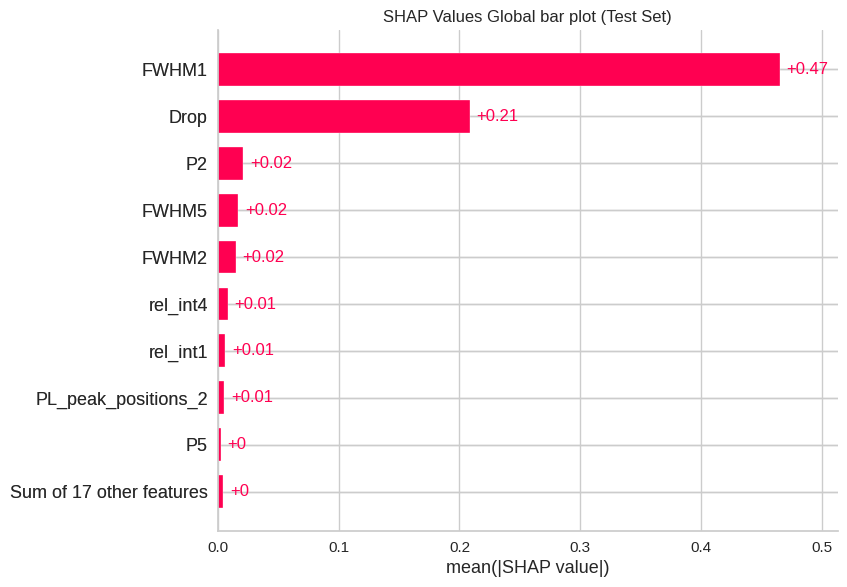

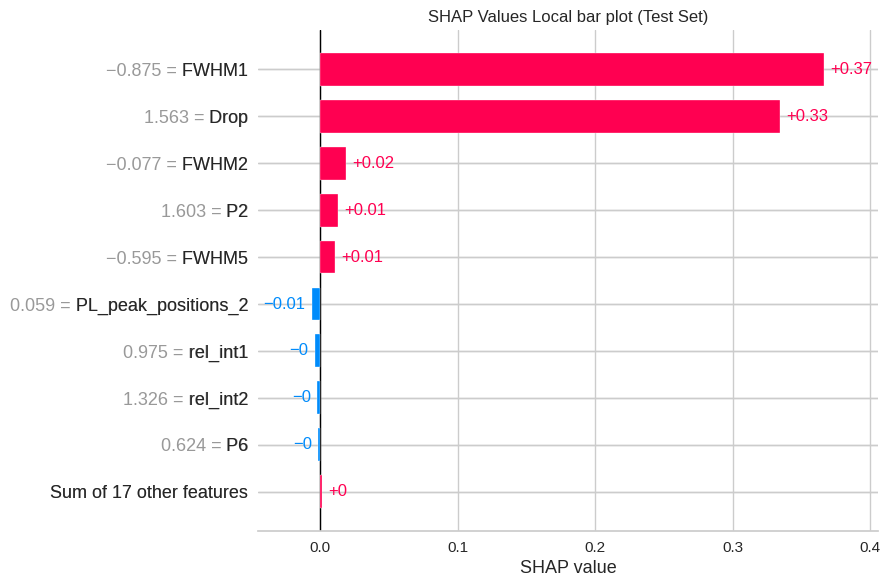

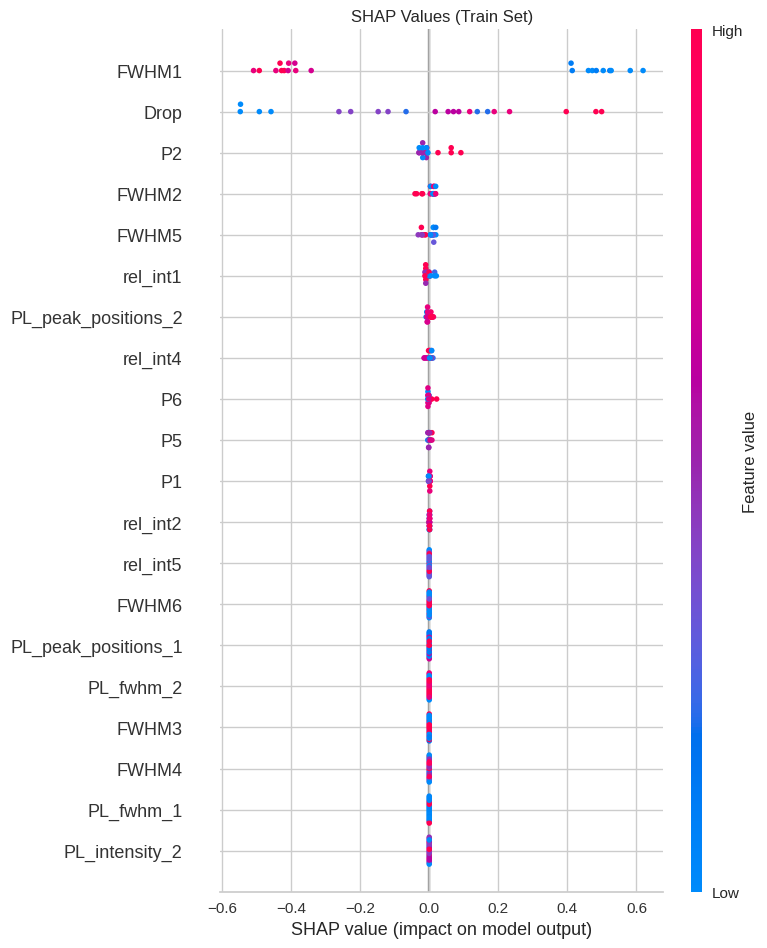

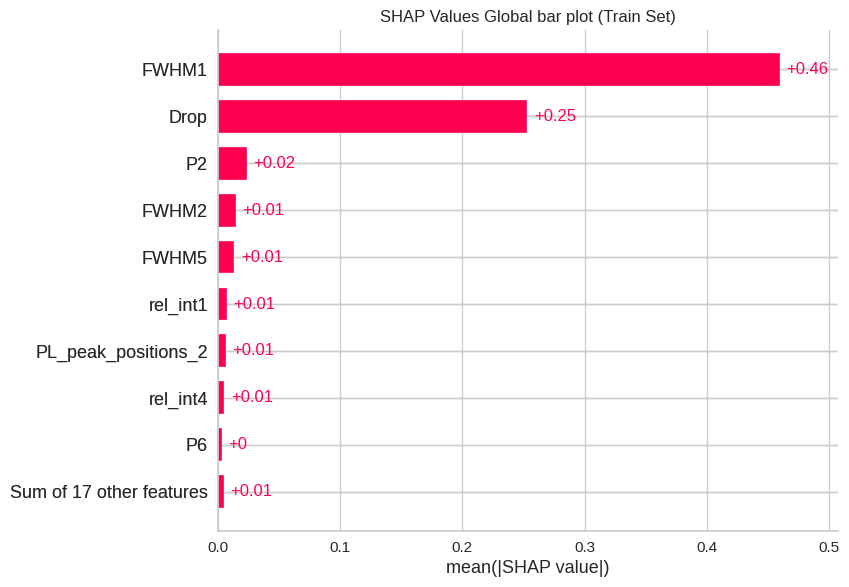

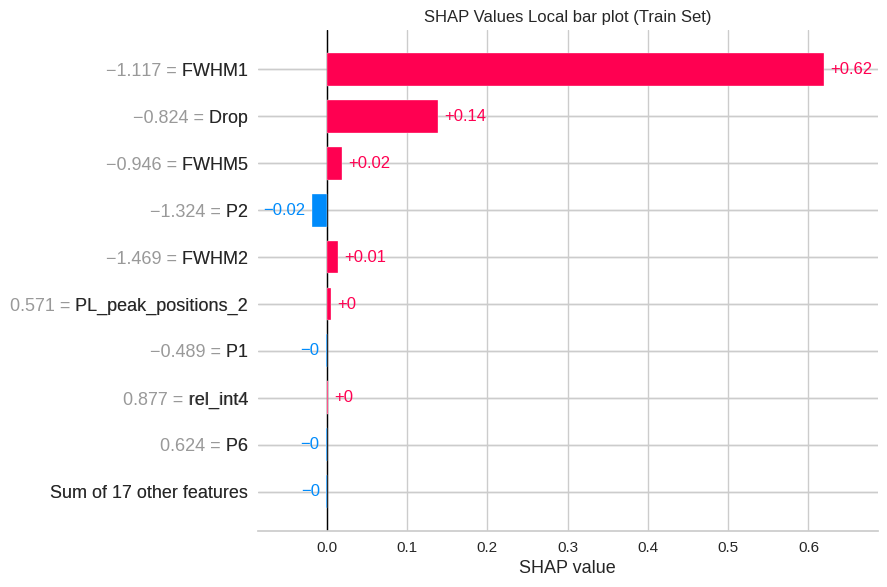

,R-squared Score (Test Set),R-squared Score (Train Set),RMSE (Test Set),RMSE (Train Set),Best max_depth,Best learning_rate,Best n_estimators,Best subsample,Best alpha,Best reg_lambda
XGBoost-Bayesian Optimization,0.823941,0.834274,0.298106,0.280409,4,0.061033,927,0.723473,0.924849,0.120789


In [22]:
###########################
def xgb_evaluate(alpha, reg_lambda, learning_rate, max_depth, n_estimators, subsample):
    model = XGBRegressor(
        alpha=alpha,
        reg_lambda=reg_lambda,
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        n_estimators=int(n_estimators),
        random_state=78,
        subsample=subsample
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Define the search space
pbounds = {
    'alpha': (0, 1),
    'reg_lambda': (0, 1),
    'learning_rate': (0.01, 0.09),
    'max_depth': (3, 10),
    'n_estimators': (50, 1000),
    'subsample': (0.5, 1.0)
}
# Perform Bayesian Optimization
optimizer = BayesianOptimization(f=xgb_evaluate, pbounds=pbounds, random_state=78)
optimizer.maximize(init_points=3, n_iter=20)

# Get the best parameters
best_params = optimizer.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])

# Train the best model
best_model = XGBRegressor(random_state=78, **best_params)
best_model.fit(X_train, y_train)

#############################
# Get the feature importances
importances = best_model.feature_importances_
importance_scores = list(zip(X.columns, importances))
importance_scores.sort(key=lambda x: x[1], reverse=True)
# Print the feature importances
print("Feature Importances:")
for feature, score in importance_scores:
    print(f"{feature}: {score:.4f}")
###################################
# Predictions on the test set and train set
y_pred_test = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)


    # Calculate R-squared values
r2_test = r2_score(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)


#############################

# Calculate SHAP values for both train and test sets
explainer = shap.Explainer(best_model,feature_names=X.columns)

shap_values_train = explainer(X_train)
shap_values_test = explainer(X_test)

# Plot SHAP summary plot for test set
shap.summary_plot(shap_values_test, X_test, feature_names=X.columns, show=False,plot_size=[8,6])
plt.title('SHAP Values (Test Set)')
plt.show()
# Plot SHAP bar plot for test set
plt.title('SHAP Values Global bar plot (Test Set)')
shap.plots.bar(shap_values_test)

# Plot SHAP bar plot for test set
plt.title('SHAP Values Local bar plot (Test Set)')
shap.plots.bar(shap_values_test[0])


# Plot SHAP summary plot for train set
shap.summary_plot(shap_values_train, X_train, feature_names=X.columns, show=False)
plt.title('SHAP Values (Train Set)')
plt.show()

# Plot SHAP bar plot for train set
plt.title('SHAP Values Global bar plot (Train Set)')
shap.plots.bar(shap_values_train)

# Plot SHAP bar plot for train set
plt.title('SHAP Values Local bar plot (Train Set)')
shap.plots.bar(shap_values_train[0])

##########
res=pd.DataFrame({
    'R-squared Score (Test Set)': [r2_test],
    'R-squared Score (Train Set)': [r2_train],
    'RMSE (Test Set)': [np.sqrt(mean_squared_error(y_test, y_pred_test))],
    'RMSE (Train Set)': [np.sqrt(mean_squared_error(y_train, y_pred_train))],
    'Best max_depth': [best_params['max_depth']],
    'Best learning_rate': [best_params['learning_rate']],
    'Best n_estimators': [best_params['n_estimators']],
    'Best subsample': [best_params['subsample']],
    'Best alpha': [best_params['alpha']],
    'Best reg_lambda': [best_params['reg_lambda']]

                                                 }, index=['XGBoost-Bayesian Optimization'])
res

##hyperOPT

  fmin from hyperopt to perform the optimization, with the Tree of Parzen Estimators (TPE) algorithm.

100%|██████████| 20/20 [00:01<00:00, 11.06trial/s, best loss: -0.8001052616869089]
Feature Importances:
FWHM1: 0.5936
rel_int4: 0.0913
Drop: 0.0882
P5: 0.0614
FWHM2: 0.0590
P2: 0.0464
P6: 0.0278
FWHM5: 0.0162
rel_int1: 0.0156
PL_peak_positions_2: 0.0004
FWHM3: 0.0000
FWHM4: 0.0000
FWHM6: 0.0000
P1: 0.0000
P3: 0.0000
P4: 0.0000
rel_int2: 0.0000
rel_int3: 0.0000
rel_int5: 0.0000
rel_int6: 0.0000
PL_intensity_1: 0.0000
PL_intensity_2: 0.0000
PL_fwhm_1: 0.0000
PL_fwhm_2: 0.0000
PL_peak_positions_1: 0.0000
Bandgap: 0.0000


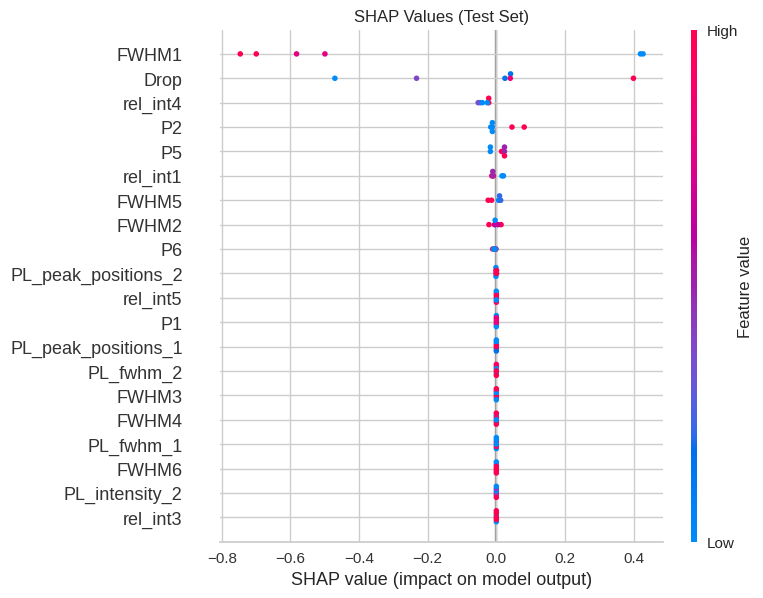

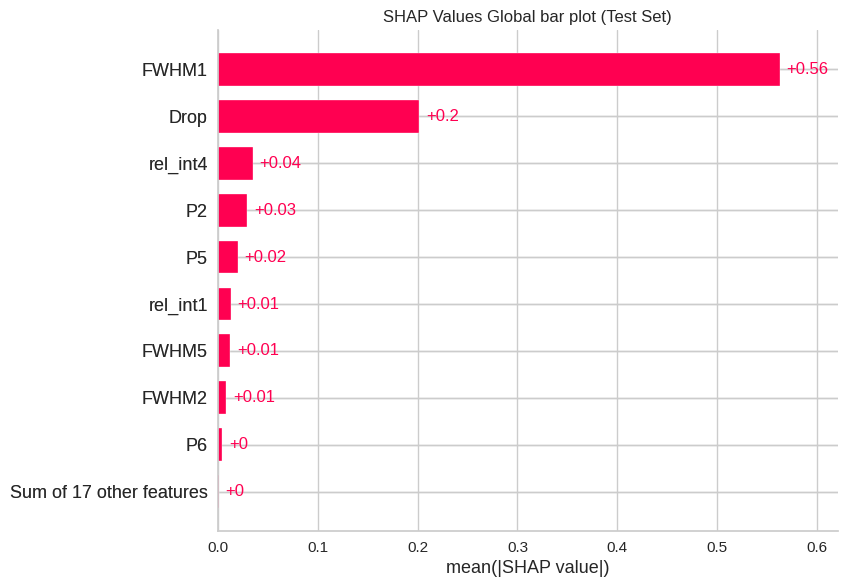

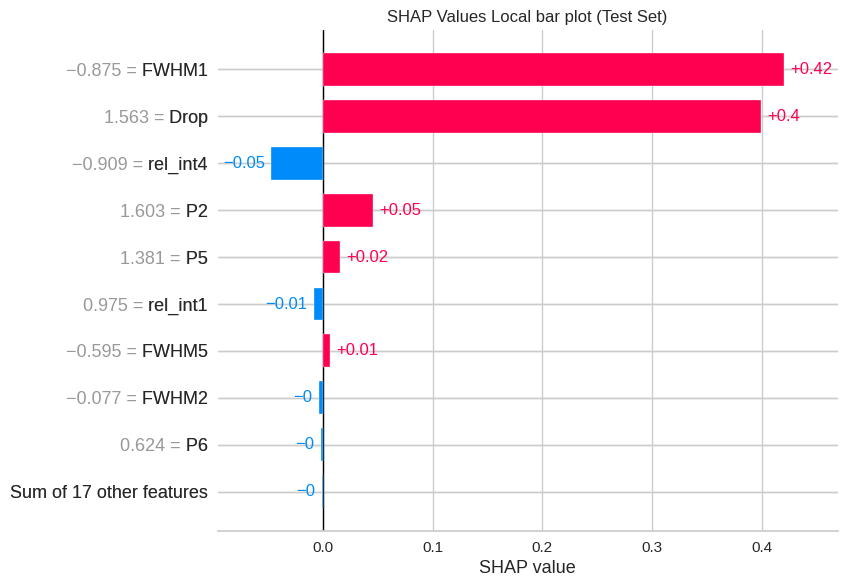

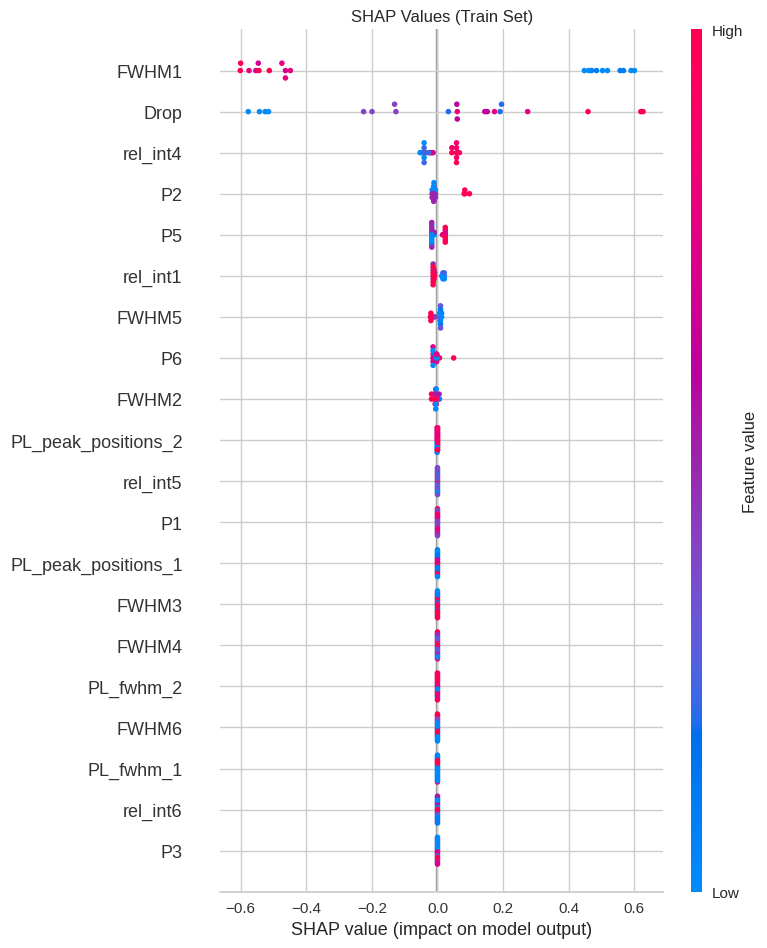

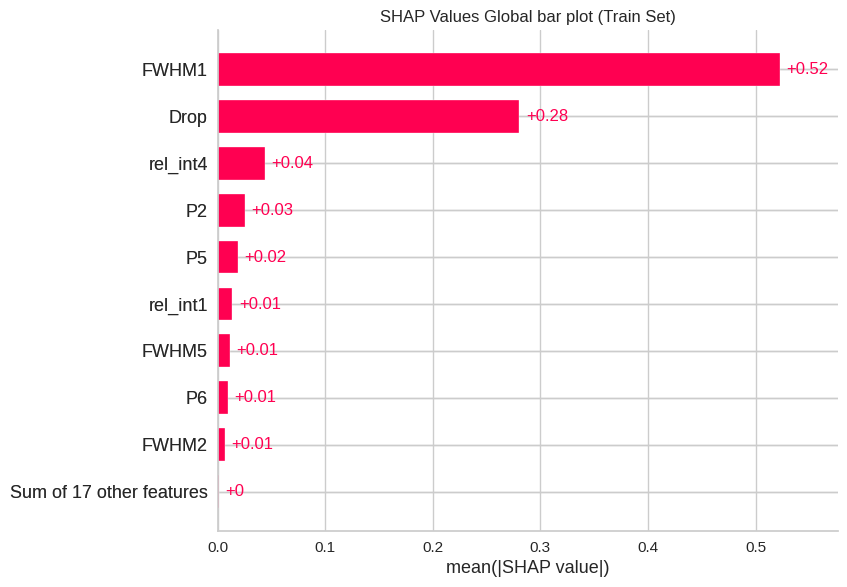

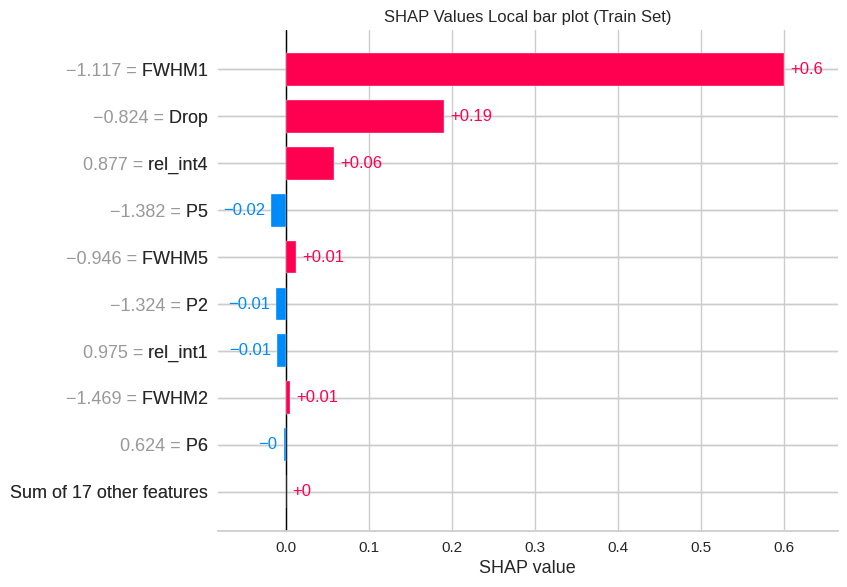

,R-squared Score (Test Set),R-squared Score (Train Set),RMSE (Test Set),RMSE (Train Set),Best max_depth,Best learning_rate,Best n_estimators,Best subsample,Best alpha,Best reg_lambda
XGBoost-Hyperopt Optimization,0.800105,0.824204,0.317645,0.288802,4,0.585011,626,0.504184,1.311001,1.869181


In [23]:
def xgb_evaluate(params):
    model = XGBRegressor(
        alpha=params['alpha'],
        reg_lambda=params['reg_lambda'],
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        n_estimators=int(params['n_estimators']),
        subsample=params['subsample'],
        random_state=78
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = r2_score(y_test, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

# Define the search space
space = {
    'alpha': hp.uniform('alpha', 0, 5),
    'reg_lambda': hp.uniform('reg_lambda', 0, 5),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.8)),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0)
}


# Perform Hyperopt optimization
trials = Trials()
best = fmin(fn=xgb_evaluate, space=space, algo=tpe.suggest, max_evals=20, trials=trials, rstate=np.random.default_rng(78))

# Get the best parameters
best_params = best.copy()
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])

# Train the best model
best_model = XGBRegressor(random_state=78, **best_params)
best_model.fit(X_train, y_train)

# Get the feature importances
importances = best_model.feature_importances_
importance_scores = list(zip(X.columns, importances))
importance_scores.sort(key=lambda x: x[1], reverse=True)
print("Feature Importances:")
for feature, score in importance_scores:
    print(f"{feature}: {score:.4f}")

# Predictions on the test set and train set
y_pred_test = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

#######

# Calculate R-squared values
r2_test = r2_score(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)

####

# Calculate SHAP values for both train and test sets
explainer = shap.Explainer(best_model, feature_names=X.columns)
shap_values_train = explainer(X_train)
shap_values_test = explainer(X_test)

# Plot SHAP summary plot for test set
shap.summary_plot(shap_values_test, X_test, feature_names=X.columns, show=False, plot_size=[8,6])
plt.title('SHAP Values (Test Set)')
plt.show()

# Plot SHAP bar plot for test set
plt.title('SHAP Values Global bar plot (Test Set)')
shap.plots.bar(shap_values_test)

# Plot SHAP bar plot for test set (local)
plt.title('SHAP Values Local bar plot (Test Set)')
shap.plots.bar(shap_values_test[0])

# Plot SHAP summary plot for train set
shap.summary_plot(shap_values_train, X_train, feature_names=X.columns, show=False)
plt.title('SHAP Values (Train Set)')
plt.show()

# Plot SHAP bar plot for train set
plt.title('SHAP Values Global bar plot (Train Set)')
shap.plots.bar(shap_values_train)

# Plot SHAP bar plot for train set (local)
plt.title('SHAP Values Local bar plot (Train Set)')
shap.plots.bar(shap_values_train[0])
#######

# Results summary
res = pd.DataFrame({
    'R-squared Score (Test Set)': [r2_test],
    'R-squared Score (Train Set)': [r2_train],
    'RMSE (Test Set)': [np.sqrt(mean_squared_error(y_test, y_pred_test))],
    'RMSE (Train Set)': [np.sqrt(mean_squared_error(y_train, y_pred_train))],
    'Best max_depth': [best_params['max_depth']],
    'Best learning_rate': [best_params['learning_rate']],
    'Best n_estimators': [best_params['n_estimators']],
    'Best subsample': [best_params['subsample']],
    'Best alpha': [best_params['alpha']],
    'Best reg_lambda': [best_params['reg_lambda']]
}, index=['XGBoost-Hyperopt Optimization'])

(res)